# 데이터 EDA 부분은 별도 코드에서 따로 처리

In [ ]:
!apt-get -qq install fonts-nanum*

Selecting previously unselected package fonts-nanum.
(Reading database ... 124788 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:

import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor


In [ ]:

# 한글 폰트 설정하기

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 기본 폰트를 나눔고딕으로 설정




# Data Load

In [ ]:

# 데이터 불러오기
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')


In [ ]:
train.columns

Index(['ID', '제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', '보증기간(년)',
       '사고이력', '연식(년)', '가격(백만원)'],
      dtype='object')

In [ ]:
train.shape

(7497, 11)

# 데이터 전처리


Point 1. 모델 별 보증기간(년)을 BoxPlot하고 'IONIQ' 모델에서 보증기간(년) 8 제거

Point 2. 주행거리
  * Band New = 0 ~ 10,000
  * Nearly New = 10,000 ~ 50,000
  * Pre-Owned = 50,000 초과

-> 여기서 Nearly New가 50,000km을 초과하는 것 제거

Point 3. 'IONIQ'
  * 배터리용량 80 이상 제거
  * 'Pre-Owned'에서 50,000km 미만 제거

Point 4. 'TayGTS'
  * 배터리용량 77과 88 사이 제거



In [ ]:
# 'IONIQ' 모델의 보증기간(년)이 8년인 경우 제거
train = train[~((train['모델'] == 'IONIQ') & (train['보증기간(년)'] == 8))]

# 차량상태가 'New Nearly'이고 주행거리가 50000 초과인 데이터 제거
train = train[~((train['차량상태'] == 'Nearly New') & (train['주행거리(km)'] > 50000))]

# 조건에 맞는 행 제거
train = train[~((train['모델'] == 'IONIQ') & (train['차량상태'] == 'Pre-Owned') & (train['주행거리(km)'] < 50000))]
train = train[~((train['모델'] == 'IONIQ') & (train['배터리용량'] >= 80))]

train = train[~((train['모델'] == 'TayGTS') & (train['배터리용량'] >= 77) & (train['배터리용량'] <= 88))]



# 배터리용량 Null 값 채우기

Point 1.
  * 보증기간(년), 제조사, 모델, 구동 방식에 따른 그룹핑 이후, 평균 채우기
  * train의 방식을 test에 적용


In [ ]:
# train 데이터프레임에서 배터리용량의 NULL 값을 보증기간, 제조사, 모델, 구동방식 별로 그룹의 평균으로 채우기
train['배터리용량'] = train['배터리용량'].fillna(
    train.groupby(['보증기간(년)', '제조사', '모델', '구동방식'])['배터리용량'].transform('mean'))

# train에서 평균값 계산
mean_battery_capacity = train.groupby(['보증기간(년)', '제조사', '모델', '구동방식'])['배터리용량'].mean()

# test 데이터프레임에서 NULL 값을 보증기간, 제조사, 모델, 구동방식 그룹의 평균으로 채우기
def fill_battery_capacity(row):
    return mean_battery_capacity.get((row['보증기간(년)'], row['제조사'], row['모델'], row['구동방식']), row['배터리용량'])

test['배터리용량'] = test['배터리용량'].fillna(test.apply(fill_battery_capacity, axis=1))

In [ ]:
train.isnull().sum()

,0
ID,0
제조사,0
모델,0
차량상태,0
배터리용량,50
구동방식,0
주행거리(km),0
보증기간(년),0
사고이력,0
연식(년),0


In [ ]:
test.isnull().sum()

,0
ID,0
제조사,0
모델,0
차량상태,0
배터리용량,3
구동방식,0
주행거리(km),0
보증기간(년),0
사고이력,0
연식(년),0


# 불필요한 데이터 컬럼 Drop

In [ ]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train = train.drop(['ID', '가격(백만원)', '연식(년)', '차량상태'], axis=1)
y_train = train['가격(백만원)']

x_test = test.drop(['ID', '연식(년)','차량상태'], axis=1)


# 범주형 데이터 Encoding

In [ ]:

# 범주형 변수에 대해 레이블 인코딩을 적용합니다.
categorical_features = [col for col in x_train.columns if x_train[col].dtype == 'object']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(x_train[i])
    x_train[i]=le.transform(x_train[i])

    for case in np.unique(x_test[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    x_test[i]=le.transform(x_test[i])

display(x_train.head(3))


,제조사,모델,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력
1,3,10,56.000,1,10199,6,0
2,0,17,91.200,0,2361,7,0
3,0,12,78.227,0,21683,3,0


# 스케일러

MinMax, Standard 등 총 4가지 스케일러 중 가장 높은 성능을 보이는 것 선택

In [ ]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# x_train 데이터에 대한 스케일링
x_train_scaled = scaler.fit_transform(x_train)

# x_test 데이터에 대한 스케일링 (train 데이터에서 변환된 스케일을 사용)
x_test_scaled = scaler.transform(x_test)

# 스케일링된 데이터를 DataFrame으로 변환
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

# 결과 확인
display(x_train_scaled.head(3))
display(x_test_scaled.head(3))


,제조사,모델,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력
0,0.130772,-0.025454,-1.281173,0.755372,-0.614434,0.317921,-0.220308
1,-1.452592,1.087762,1.017910,-0.612828,-0.755710,0.635156,-0.220308
2,-1.452592,0.292608,0.170580,-0.612828,-0.407442,-0.633786,-0.220308


,제조사,모델,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력
0,0.658560,0.769700,0.031198,-0.612828,-0.544896,-0.951022,-0.220308
1,-0.924804,1.564854,0.939532,-0.612828,-0.662235,0.952392,-0.220308
2,-0.924804,1.405823,0.939532,2.123572,-0.668544,0.635156,4.539108


# LGBM Regressor

1. GridSearchCV을 활용한 최적 파라미터 찾기

2. 최적 변수 cv=5 선택

3. Validation은 대회 초반 이후 별도로 수행하지 않고 제출 성능에 맞춰서 성능 비교

In [ ]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# LightGBM 모델 학습
lightgbm_model = LGBMRegressor(random_state=42)
# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 20],
    'num_leaves': [10, 20, 30],
    'min_child_samples': [40, 50, 60]
}

# GridSearchCV 정의
grid_search1 = GridSearchCV(estimator=lightgbm_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=1)

# 모델 학습
grid_search1.fit(x_train_scaled, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search1.best_params_)
print("최고의 점수:", np.sqrt(-grid_search1.best_score_))  # RMSE로 변환

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 7410, number of used features: 7
[LightGBM] [Info] Start training from score 62.601964
최적의 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 40, 'n_estimators': 500, 'num_leaves': 10}
최고의 점수: 1.2601246165193654


In [ ]:
# 예측을 위한 각 모델의 예측 수행

lightgbm_predictions = grid_search1.predict(x_test_scaled)

# Feature Importance

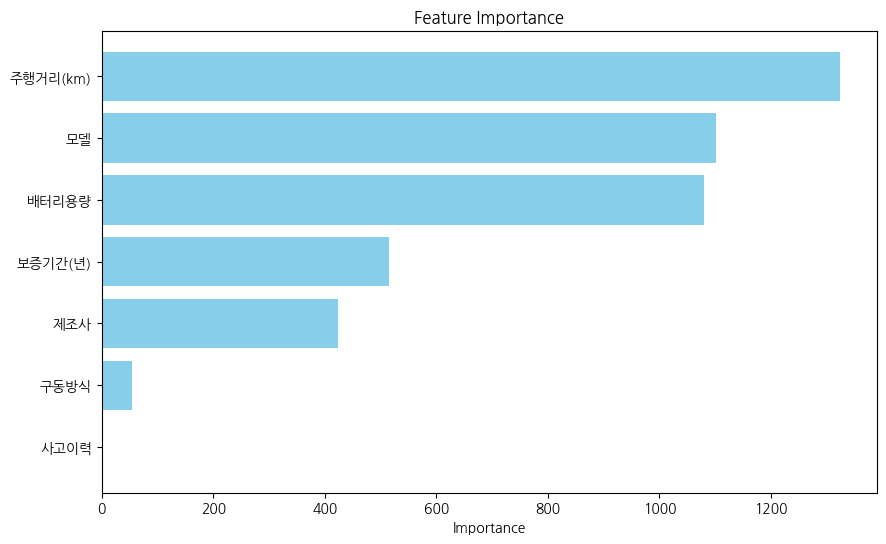

In [ ]:
# 피처 중요도 추출
importance = grid_search1.best_estimator_.feature_importances_

# 피처 중요도 데이터프레임 생성
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# 중요도 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 상위 중요도를 위로
plt.show()


In [ ]:
# sample_submission 파일을 불러옵니다.
submit1 = pd.read_csv('./sample_submission.csv')


In [ ]:
submit1['가격(백만원)'] = lightgbm_predictions

In [ ]:
submit1

,ID,가격(백만원)
0,TEST_000,130.388055
1,TEST_001,80.038313
2,TEST_002,65.285704
3,TEST_003,35.182705
4,TEST_004,47.936954
...,...,...
841,TEST_841,151.511210
842,TEST_842,38.610337
843,TEST_843,38.709455
844,TEST_844,58.768860


# 이전 제출 성능과 비교

RMSE: 0.15994925815864916


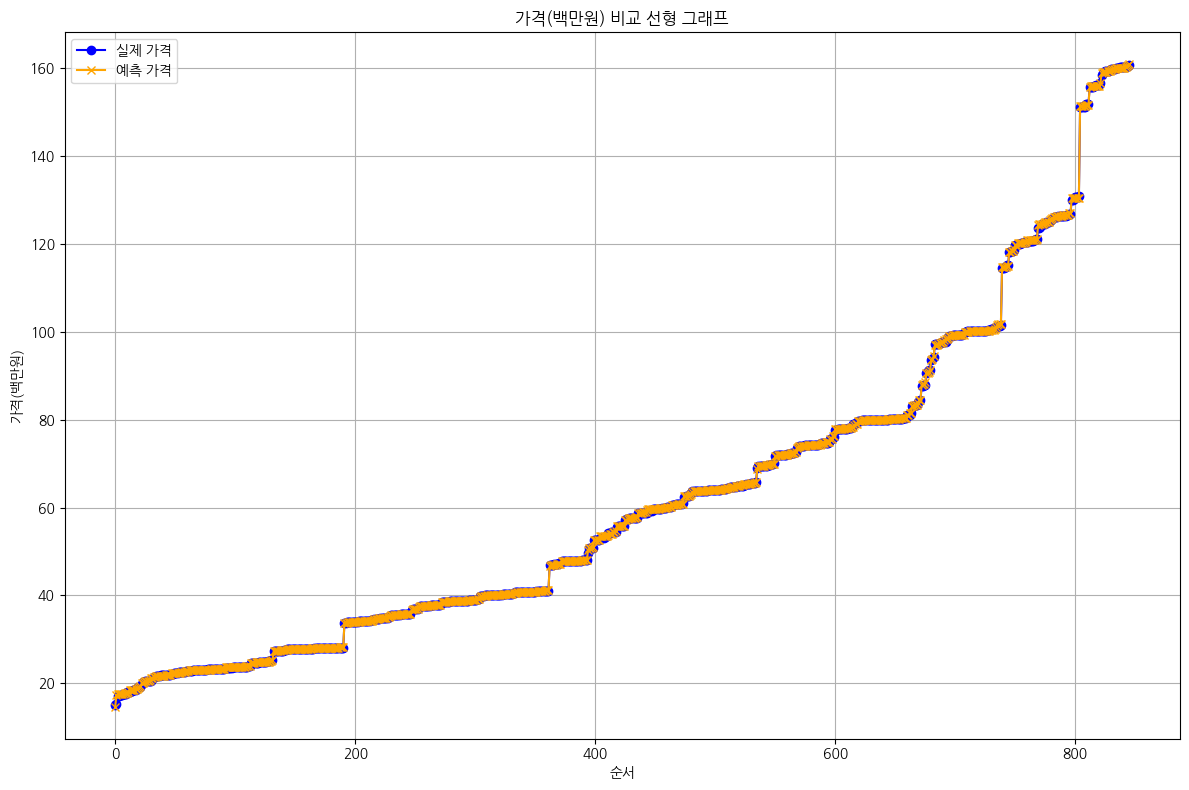

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
data = pd.read_csv('test_baseline263.csv')

# 가격을 기준으로 정렬
data_sorted = data.sort_values(by='가격(백만원)')

# submit1 데이터프레임도 가격을 기준으로 정렬
submit1_sorted = submit1.sort_values(by='가격(백만원)')

# RMSE 계산
actual_prices = data_sorted['가격(백만원)'].reset_index(drop=True)
predicted_prices = submit1_sorted['가격(백만원)'].reset_index(drop=True)

rmse = np.sqrt(np.mean((actual_prices - predicted_prices) ** 2))

print("RMSE:", rmse)

# 선형 그래프 그리기
plt.figure(figsize=(12, 8))

# 실제 가격 그래프
plt.plot(data_sorted['가격(백만원)'].reset_index(drop=True), marker='o', color='blue', label='실제 가격')

# 예측된 가격 그래프
plt.plot(submit1_sorted['가격(백만원)'].reset_index(drop=True), marker='x', color='orange', label='예측 가격')

# 그래프 제목 및 레이블 설정
plt.title('가격(백만원) 비교 선형 그래프')
plt.xlabel('순서')
plt.ylabel('가격(백만원)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
data

,ID,가격(백만원)
0,TEST_000,130.775741
1,TEST_001,80.041749
2,TEST_002,64.875324
3,TEST_003,34.792047
4,TEST_004,47.877095
...,...,...
841,TEST_841,151.208123
842,TEST_842,38.686184
843,TEST_843,38.788317
844,TEST_844,58.689323


In [ ]:
submit1

,ID,가격(백만원)
0,TEST_000,130.388055
1,TEST_001,80.038313
2,TEST_002,65.285704
3,TEST_003,35.182705
4,TEST_004,47.936954
...,...,...
841,TEST_841,151.511210
842,TEST_842,38.610337
843,TEST_843,38.709455
844,TEST_844,58.768860


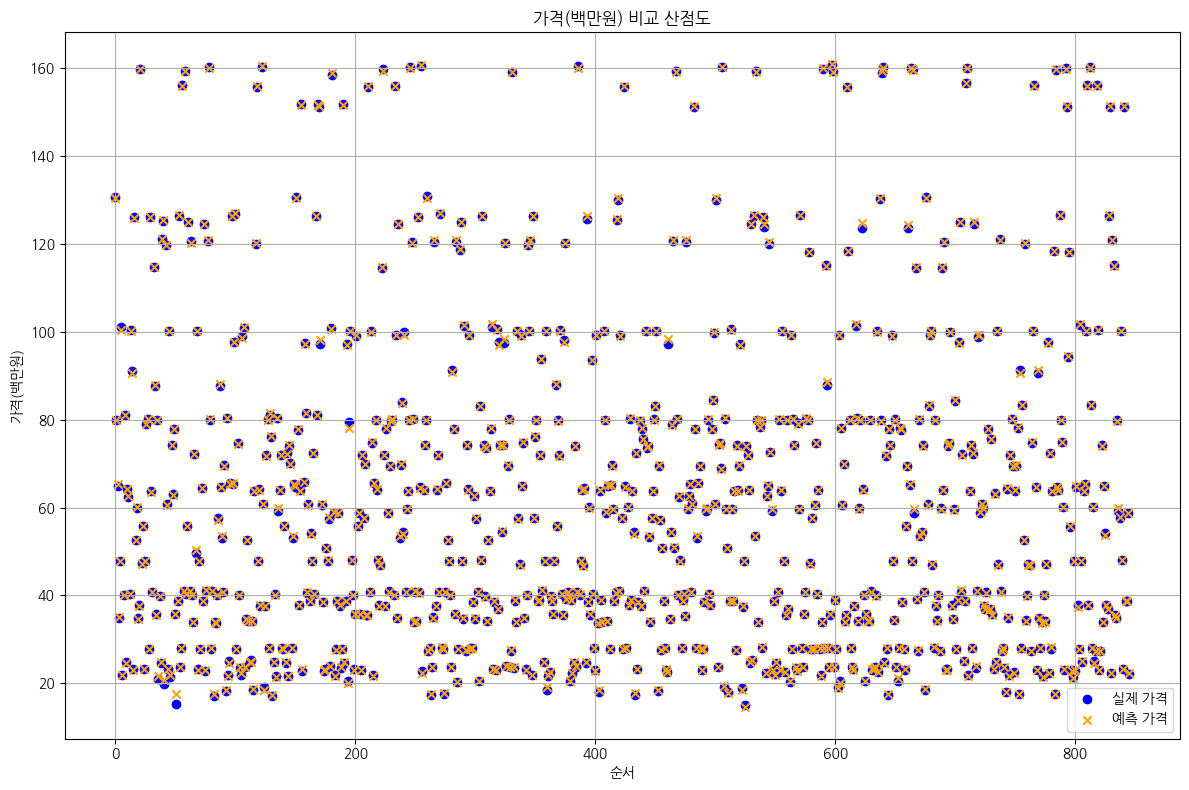

In [ ]:


# 데이터 불러오기
data = pd.read_csv('test_baseline263.csv')

# 그래프 크기 조정
plt.figure(figsize=(12, 8))

# 실제 가격 산점도
plt.scatter(data.index, data['가격(백만원)'], marker='o', color='blue', label='실제 가격')

# 예측된 가격 산점도
plt.scatter(submit1.index, submit1['가격(백만원)'], marker='x', color='orange', label='예측 가격')

# 그래프 제목 및 레이블 설정
plt.title('가격(백만원) 비교 산점도')
plt.xlabel('순서')
plt.ylabel('가격(백만원)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
submit1.to_csv('./test_baseline268.csv',index=False)